In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the data
features = pd.read_csv('/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/data/features.csv')
labels = pd.read_csv('/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/data/labels.csv')
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

In [8]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels['Type'])

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate specificity
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn / (tn + fp)
    specificity = np.mean(specificity)
    
    return accuracy, recall, specificity, f1, cm

In [13]:
def train_and_evaluate(X, y, model_name, n_splits=4):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    cumulative_cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)
    
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_fold_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_fold_train, y_val = y[train_index], y[val_index]
        
        # Balance the dataset if specified
        if model_name == "Balanced Model":
            smote = SMOTE(random_state=42)
            X_fold_train, y_fold_train = smote.fit_resample(X_fold_train, y_fold_train)
        
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_val_scaled = scaler.transform(X_val)
        
        mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        mlp.fit(X_fold_train_scaled, y_fold_train)
        
        y_pred = mlp.predict(X_val_scaled)
        
        accuracy, sensitivity, specificity, f1, cm = calculate_metrics(y_val, y_pred)
        fold_metrics.append((accuracy, sensitivity, specificity, f1))
        
        cumulative_cm += cm
    
    avg_metrics = np.mean(fold_metrics, axis=0)
    avg_cm = cumulative_cm / n_splits
    
    print(f"\n--- {model_name} - Average Cross-Validation Performance ---")
    print(f"Accuracy: {avg_metrics[0]:.4f}")
    print(f"Sensitivity: {avg_metrics[1]:.4f}")
    print(f"Specificity: {avg_metrics[2]:.4f}")
    print(f"F1 Score: {avg_metrics[3]:.4f}")
    
    # Plot and save the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Average Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.savefig(f'/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/results/avg_confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.close()
    
    return avg_metrics

In [12]:
# Train and evaluate the imbalanced model
imbalanced_metrics = train_and_evaluate(X_train, y_train, "Imbalanced Model")


--- Imbalanced Model - Fold 1 ---
Accuracy: 0.9853
Sensitivity: 0.9853
Specificity: 0.9959
F1 Score: 0.9845

--- Imbalanced Model - Fold 2 ---
Accuracy: 0.9809
Sensitivity: 0.9809
Specificity: 0.9945
F1 Score: 0.9798

--- Imbalanced Model - Fold 3 ---
Accuracy: 0.9849
Sensitivity: 0.9849
Specificity: 0.9959
F1 Score: 0.9845

--- Imbalanced Model - Fold 4 ---
Accuracy: 0.9849
Sensitivity: 0.9849
Specificity: 0.9960
F1 Score: 0.9847

--- Imbalanced Model - Average Cross-Validation Performance ---
Accuracy: 0.9840
Sensitivity: 0.9840
Specificity: 0.9956
F1 Score: 0.9834


In [14]:
# Train and evaluate the balanced model
balanced_metrics = train_and_evaluate(X_train, y_train, "Balanced Model")


--- Balanced Model - Fold 1 ---
Accuracy: 0.9747
Sensitivity: 0.9747
Specificity: 0.9918
F1 Score: 0.9743

--- Balanced Model - Fold 2 ---
Accuracy: 0.9729
Sensitivity: 0.9729
Specificity: 0.9920
F1 Score: 0.9725

--- Balanced Model - Fold 3 ---
Accuracy: 0.9778
Sensitivity: 0.9778
Specificity: 0.9939
F1 Score: 0.9772

--- Balanced Model - Fold 4 ---
Accuracy: 0.9791
Sensitivity: 0.9791
Specificity: 0.9941
F1 Score: 0.9786

--- Balanced Model - Average Cross-Validation Performance ---
Accuracy: 0.9761
Sensitivity: 0.9761
Specificity: 0.9929
F1 Score: 0.9756


In [15]:
# Train the final model on the entire training set
final_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
final_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [16]:
# Evaluate on the test set
X_test_scaled = scaler.transform(X_test)
y_test_pred = final_model.predict(X_test_scaled)
accuracy, sensitivity, specificity, f1, cm = calculate_metrics(y_test, y_test_pred)
print("\n--- Final Model Evaluation on Test Set ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")


--- Final Model Evaluation on Test Set ---
Accuracy: 0.9850
Sensitivity: 0.9850
Specificity: 0.9960
F1 Score: 0.9850


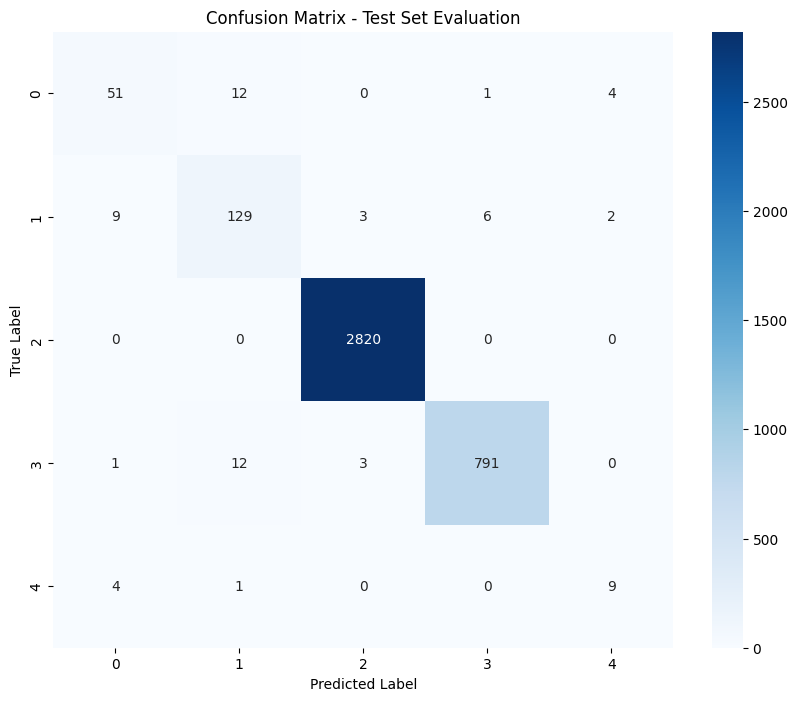

In [17]:
# Plot confusion matrix for test set evaluation
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set Evaluation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
plt.savefig('/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/results/confusion_matrix_test_set.png')
plt.close()

In [ ]:
# Plot class distribution in original dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=le.inverse_transform(y))
plt.title('Class Distribution in Original Dataset')
plt.xlabel('Subcellular Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
plt.savefig('/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/results/class_distribution_imbalanced.png')
plt.close()

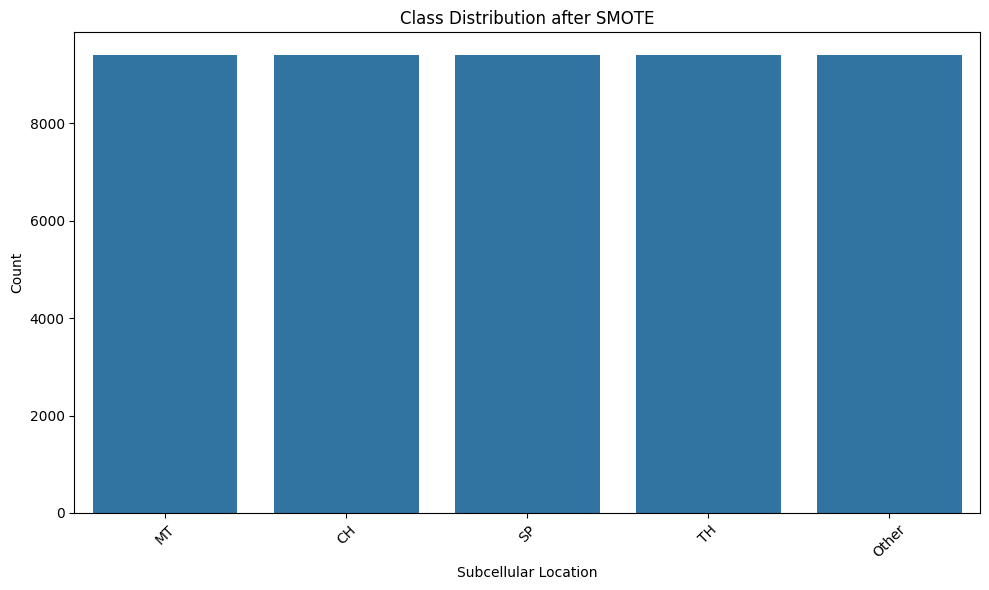

In [19]:
# Plot class distribution after balancing (for visualization only)
smote = SMOTE(random_state=42)
_, y_balanced = smote.fit_resample(features, y)
plt.figure(figsize=(10, 6))
sns.countplot(x=le.inverse_transform(y_balanced))
plt.title('Class Distribution after SMOTE')
plt.xlabel('Subcellular Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
plt.savefig('/mnt/c/Users/Linda/Desktop/GitHub_Projects/MLP_ProteinLocalization/results/class_distribution_balanced.png')
plt.close()